# SAR Linear Regression

## Spatially Adjusted Regression - Linear Models

Ordinary Least Squares vs Spatial Simultaneous Autoregressive Models


In [1]:
# Load relevant R packages
inLibraries = list('repr','rgdal','spdep','classInt','car','RColorBrewer','MASS','geoR')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
“no DISPLAY variable so Tk is not available”

## US Farming Data

In this practice, we will be working with county data on agricultural practices in the USA (usagriculture/usfarming.shp). Elements of this dataset were obtained from the 2012 US ag. census: https://www.agcensus.usda.gov/Publications/2012/Online_Resources/Ag_Census_Web_Maps/Data_download/index.php. The fields in this dataset may seem kinda mystical, but they are documented in depth at the website noted above (download the excel and/or pdf file).

While the Agriculture Census data is great for agricultural info, there is also some county level US Census data that we'd like to use that contains better detail about the human population associated with US counties.  The US Census county-level polygon data can be found at (us_counties/UScounties.shp).

Read in the Ag. Census and US Census county featureclasses.

In [2]:
ag <- readOGR("/dsa/data/geospatial/DS8612/usagriculture","usfarming")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/usagriculture", layer: "usfarming"
with 3070 features
It has 93 fields


In [3]:
census <- readOGR("/dsa/data/geospatial/DS8612/us_counties", "UScounties")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/us_counties", layer: "UScounties"
with 3109 features
It has 22 fields


In [4]:
t(head(ag@data, 3))

,0,1,2
Join_Count,1,2,2
TARGET_FID,0,1,2
atlas_stco,01001,01003,01005
atlas_name,Autauga,Baldwin,Barbour
atlas_caps,AUTAUGA,BALDWIN,BARBOUR
atlas_area,594.437,1589.840,884.876
atlas_acre,380439.7,1017497.6,566320.6
entity,County,County,County
cntya,001,003,005
cntyn,1,3,5


In [5]:
t(head(census@data, 3))

,0,1,2
OBJECTID,8,9,10
ID,24011,24019,24039
NAME,Caroline,Dorchester,Somerset
STATE_NAME,Maryland,Maryland,Maryland
ST_ABBREV,MD,MD,MD
AREA,324.2379,573.7993,331.3127
TOTPOP00,29772,30674,24747
FAMPOP00,24729,24353,15917
RURALFARM,1105,604,595
FAMHH00,8156,8506,5444


Select only Ag. Census and US Census counties in the state of North Carolina. Map the selected counties. 

In [6]:
# FIP Code for North Carolina = 37
# According to https://www.mcc.co.mercer.pa.us/dps/state_fips_code_listing.htm

# subset the atlast_stco column first to obtain the first 2 digits
ag@data$stcode <- substr(ag@data$atlas_stco, start = 1, stop = 2)
head(ag@data$stcode)

[1] "01" "01" "01" "01" "01" "01"

In [7]:
ag_nc <- ag[grep("37", ag@data$stcode), ]
paste(length(ag_nc), "polygons for North Carolina Ag")

[1] "100 polygons for North Carolina Ag"

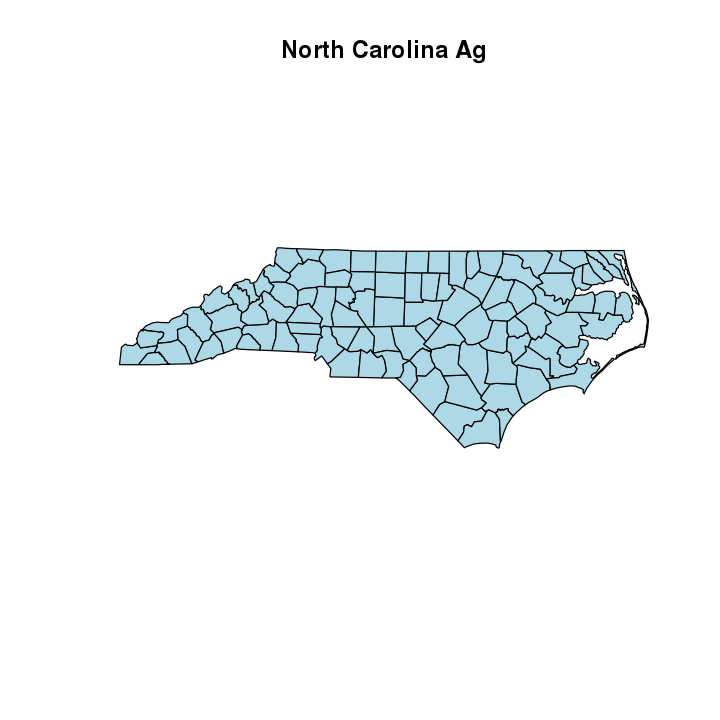

In [8]:
plot(ag_nc, col = "lightblue", main = "North Carolina Ag")

In [9]:
census_nc <- census[grep("North Carolina", census@data$STATE_NAME), ]
paste(length(census_nc), "polygons for North Carolina Census")

[1] "100 polygons for North Carolina Census"

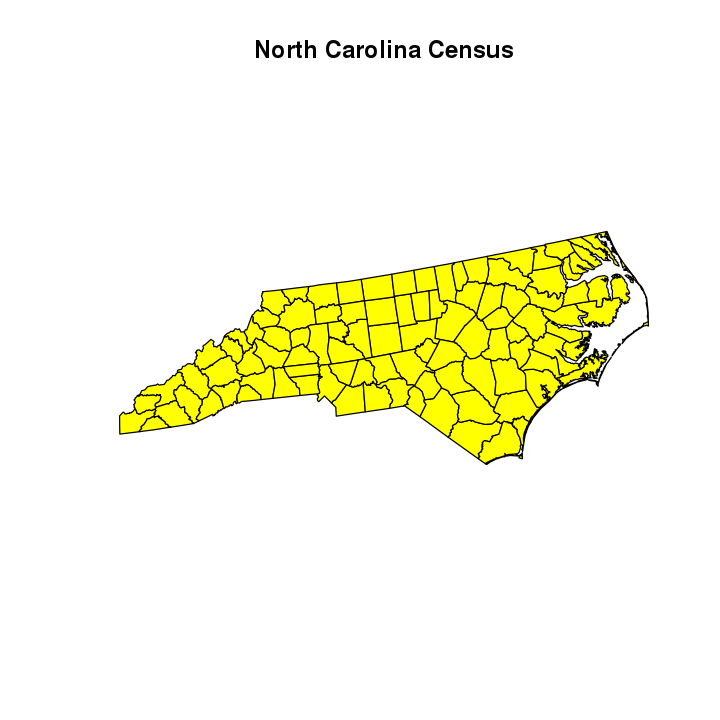

In [10]:
plot(census_nc, col = "yellow", main = "North Carolina Census")

Join the selected US Census data to the selected Ag. Census data. This can be an attribute join by FIPs code.

In [11]:
# let's make sure their CRS are aligned properly. 

In [12]:
proj4string(ag_nc)

[1] "+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [13]:
proj4string(census_nc)

[1] "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0"

In [14]:
# Not aligned. I'm going to project census_nc to ag_nc's CRS

census_nc_proj <- spTransform(census_nc, CRS("+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"))

proj4string(census_nc_proj)

[1] "+proj=longlat +datum=NAD83 +no_defs +ellps=GRS80 +towgs84=0,0,0"

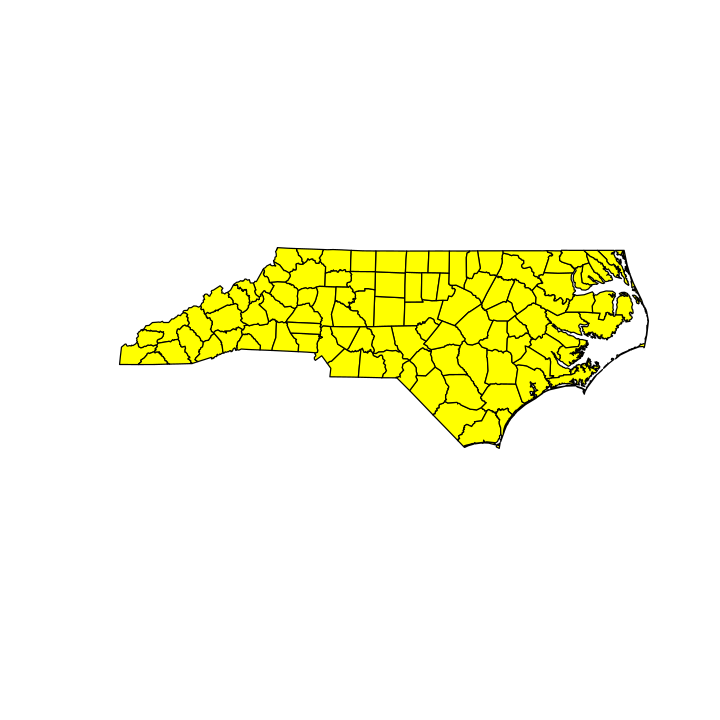

In [15]:
plot(census_nc_proj, col = "yellow")

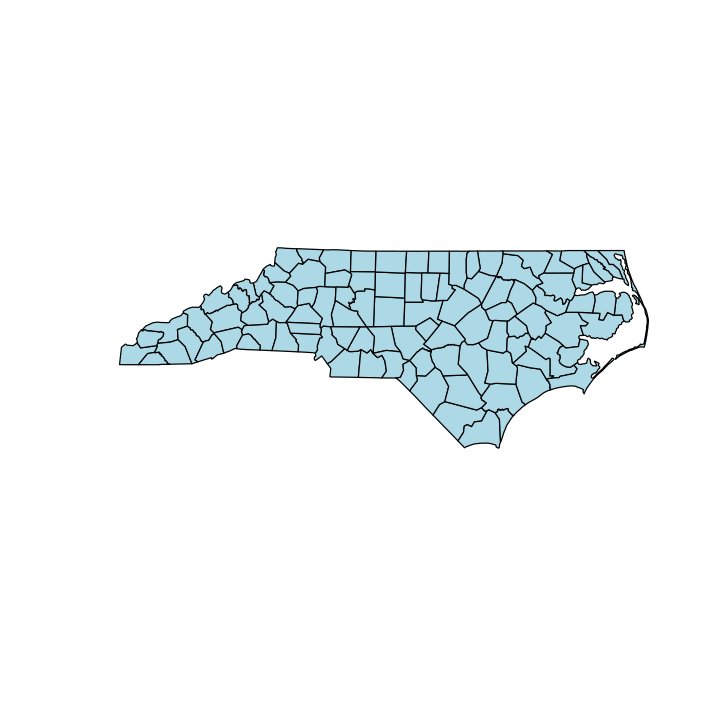

In [16]:
plot(ag_nc, col = "lightblue")

In [17]:
head(census_nc_proj@data)

,OBJECTID,ID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,FEMALES00,WHITE00,BLACK00,AGGHOMEVAL,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,Genshp_Len,Genshp_Are
1437,1470,37087,Haywood,North Carolina,NC,554.6455,54033,44244,843,16043,⋯,28136,52330,684,681258500,54033,23100,28640,2241,182364.9,1437400225
1438,1471,37115,Madison,North Carolina,NC,451.5772,19635,15697,1273,5595,⋯,9951,19169,162,100860500,19635,8000,9722,440,175539.4,1166862824
2504,2537,37005,Alleghany,North Carolina,NC,235.5009,10677,8711,640,3169,⋯,5418,10217,131,101775000,10677,4593,6412,554,127220.6,607837195
2505,2538,37009,Ashe,North Carolina,NC,426.7859,24384,20421,1038,7422,⋯,12353,23691,162,244242500,24384,10411,13268,1173,147323.8,1108049436
2553,2586,37039,Cherokee,North Carolina,NC,466.5996,24298,20373,312,7373,⋯,12512,23040,387,208654500,24298,10336,13499,1213,171400.5,1209054257
2554,2587,37043,Clay,North Carolina,NC,220.5807,8775,7320,206,2727,⋯,4503,8600,70,92466500,8775,3847,5425,457,125013.7,567595296


In [18]:
head(ag_nc@data)

,Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M264_c,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode
1853,1,1853,37001,Alamance,ALAMANCE,423.828,271249.9,County,001,1,⋯,Sparse Data,0.03,0.00,Less than 1,0.00,0.24,Less than 1,0.24,NA,37
1854,3,1854,37003,Alexander,ALEXANDER,259.956,166371.8,County,003,3,⋯,Sparse Data,1.68,0.00,Less than 1,0.00,0.27,Less than 1,0.27,NA,37
1855,2,1855,37005,Alleghany,ALLEGHANY,235.060,150438.4,County,005,5,⋯,Sparse Data,3.13,0.01,Less than 1,0.01,(D),Less than 1,0.00,NA,37
1856,1,1856,37007,Anson,ANSON,531.451,340128.6,County,007,7,⋯,Sparse Data,2.06,(D),Less than 1,0.00,7.49,6 - 8,7.49,NA,37
1857,2,1857,37009,Ashe,ASHE,426.151,272736.6,County,009,9,⋯,Sparse Data,1.00,0.05,Less than 1,0.05,(D),Less than 1,0.00,NA,37
1858,3,1858,37011,Avery,AVERY,247.088,158136.3,County,011,11,⋯,Sparse Data,-0.58,0.00,Less than 1,0.00,0.00,Less than 1,0.00,NA,37


In [19]:
dim(census_nc_proj)

[1] 100  22

In [20]:
dim(ag_nc)

[1] 100  94

In [21]:
head(census_nc_proj@data)

,OBJECTID,ID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,FEMALES00,WHITE00,BLACK00,AGGHOMEVAL,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,Genshp_Len,Genshp_Are
1437,1470,37087,Haywood,North Carolina,NC,554.6455,54033,44244,843,16043,⋯,28136,52330,684,681258500,54033,23100,28640,2241,182364.9,1437400225
1438,1471,37115,Madison,North Carolina,NC,451.5772,19635,15697,1273,5595,⋯,9951,19169,162,100860500,19635,8000,9722,440,175539.4,1166862824
2504,2537,37005,Alleghany,North Carolina,NC,235.5009,10677,8711,640,3169,⋯,5418,10217,131,101775000,10677,4593,6412,554,127220.6,607837195
2505,2538,37009,Ashe,North Carolina,NC,426.7859,24384,20421,1038,7422,⋯,12353,23691,162,244242500,24384,10411,13268,1173,147323.8,1108049436
2553,2586,37039,Cherokee,North Carolina,NC,466.5996,24298,20373,312,7373,⋯,12512,23040,387,208654500,24298,10336,13499,1213,171400.5,1209054257
2554,2587,37043,Clay,North Carolina,NC,220.5807,8775,7320,206,2727,⋯,4503,8600,70,92466500,8775,3847,5425,457,125013.7,567595296


In [22]:
head(ag_nc@data)

,Join_Count,TARGET_FID,atlas_stco,atlas_name,atlas_caps,atlas_area,atlas_acre,entity,cntya,cntyn,⋯,y12_M264_c,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode
1853,1,1853,37001,Alamance,ALAMANCE,423.828,271249.9,County,001,1,⋯,Sparse Data,0.03,0.00,Less than 1,0.00,0.24,Less than 1,0.24,NA,37
1854,3,1854,37003,Alexander,ALEXANDER,259.956,166371.8,County,003,3,⋯,Sparse Data,1.68,0.00,Less than 1,0.00,0.27,Less than 1,0.27,NA,37
1855,2,1855,37005,Alleghany,ALLEGHANY,235.060,150438.4,County,005,5,⋯,Sparse Data,3.13,0.01,Less than 1,0.01,(D),Less than 1,0.00,NA,37
1856,1,1856,37007,Anson,ANSON,531.451,340128.6,County,007,7,⋯,Sparse Data,2.06,(D),Less than 1,0.00,7.49,6 - 8,7.49,NA,37
1857,2,1857,37009,Ashe,ASHE,426.151,272736.6,County,009,9,⋯,Sparse Data,1.00,0.05,Less than 1,0.05,(D),Less than 1,0.00,NA,37
1858,3,1858,37011,Avery,AVERY,247.088,158136.3,County,011,11,⋯,Sparse Data,-0.58,0.00,Less than 1,0.00,0.00,Less than 1,0.00,NA,37


In [23]:
joined <- merge(x = census_nc_proj, y = ag_nc@data, 
                   by.x = "ID", by.y = "atlas_stco", 
                   all = TRUE)

dim(joined)

Warning message in merge.data.frame(x@data, y, by = by, by.x = by.x, by.y = by.y, :
“column name ‘ID’ is duplicated in the result”

[1] 100 115

In [24]:
head(joined@data)

,ID,OBJECTID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,y12_M264_c,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode
44,37087,1470,Haywood,North Carolina,NC,554.6455,54033,44244,843,16043,⋯,Sparse Data,-1.15,0.00,Less than 1,0.00,0.04,Less than 1,0.04,NA,37
58,37115,1471,Madison,North Carolina,NC,451.5772,19635,15697,1273,5595,⋯,Sparse Data,-4.47,0.00,Less than 1,0.00,0.15,Less than 1,0.15,NA,37
3,37005,2537,Alleghany,North Carolina,NC,235.5009,10677,8711,640,3169,⋯,Sparse Data,3.13,0.01,Less than 1,0.01,(D),Less than 1,0.00,NA,37
5,37009,2538,Ashe,North Carolina,NC,426.7859,24384,20421,1038,7422,⋯,Sparse Data,1.00,0.05,Less than 1,0.05,(D),Less than 1,0.00,NA,37
20,37039,2586,Cherokee,North Carolina,NC,466.5996,24298,20373,312,7373,⋯,Sparse Data,4.06,(D),Less than 1,0.00,0.39,Less than 1,0.39,NA,37
22,37043,2587,Clay,North Carolina,NC,220.5807,8775,7320,206,2727,⋯,Sparse Data,4.41,0.00,Less than 1,0.00,(D),Less than 1,0.00,NA,37


Generate neighborhoods for each feature according to the Queen's Criterion.  Then test the neighborhoods to see if they are valid.  Retain only the features with valid neighborhoods.

In [25]:
joined.nb <- poly2nb(joined, queen = TRUE)

In [26]:
head(joined.nb)

[[1]]
[1]  2  8  9 11 13 16

[[2]]
[1]  1 13 21

[[3]]
[1]  4 29 31

[[4]]
[1]  3 28 29

[[5]]
[1]  6  7 10

[[6]]
[1]  5 10

In [27]:
length(joined.nb)

[1] 100

In [28]:
# sift out features without neighbors

has.nb <- card(joined.nb) >= 1

joined <- joined[has.nb, ]

In [29]:
joined.nb <- poly2nb(joined, queen = TRUE)

length(joined.nb)

[1] 100

In [30]:
# get nb lists

joined.nb.listb <- nb2listw(joined.nb, style = "B")
joined.nb.listw <- nb2listw(joined.nb, style = "W")

In [31]:
head(joined.nb.listb$weights)

[[1]]
[1] 1 1 1 1 1 1

[[2]]
[1] 1 1 1

[[3]]
[1] 1 1 1

[[4]]
[1] 1 1 1

[[5]]
[1] 1 1 1

[[6]]
[1] 1 1

In [32]:
head(joined.nb.listw$weights)

[[1]]
[1] 0.1666667 0.1666667 0.1666667 0.1666667 0.1666667 0.1666667

[[2]]
[1] 0.3333333 0.3333333 0.3333333

[[3]]
[1] 0.3333333 0.3333333 0.3333333

[[4]]
[1] 0.3333333 0.3333333 0.3333333

[[5]]
[1] 0.3333333 0.3333333 0.3333333

[[6]]
[1] 0.5 0.5

Configure analysis variables. The response variable should be 'y12_M247_1' and the explanatory variable should be population density = 'TOTPOP00/AREA'.

In [33]:
# y = response variable
# acres of irrigated land as percent of land in farms acreage
inVa <- joined$y12_M247_1
Y_Var <- inVa

In [34]:
# x = explanatory variable
joined$explanatory <- joined$TOTPOP00 / joined$AREA
Ex_Var <- joined$explanatory

In [35]:
head(joined@data)

,ID,OBJECTID,NAME,STATE_NAME,ST_ABBREV,AREA,TOTPOP00,FAMPOP00,RURALFARM,FAMHH00,⋯,y12_M264_1,y12_M265_v,y12_M265_c,y12_M265_1,y12_M266_v,y12_M266_c,y12_M266_1,coastal,stcode,explanatory
44,37087,1470,Haywood,North Carolina,NC,554.6455,54033,44244,843,16043,⋯,-1.15,0.00,Less than 1,0.00,0.04,Less than 1,0.04,NA,37,97.41899
58,37115,1471,Madison,North Carolina,NC,451.5772,19635,15697,1273,5595,⋯,-4.47,0.00,Less than 1,0.00,0.15,Less than 1,0.15,NA,37,43.48094
3,37005,2537,Alleghany,North Carolina,NC,235.5009,10677,8711,640,3169,⋯,3.13,0.01,Less than 1,0.01,(D),Less than 1,0.00,NA,37,45.33742
5,37009,2538,Ashe,North Carolina,NC,426.7859,24384,20421,1038,7422,⋯,1.00,0.05,Less than 1,0.05,(D),Less than 1,0.00,NA,37,57.13404
20,37039,2586,Cherokee,North Carolina,NC,466.5996,24298,20373,312,7373,⋯,4.06,(D),Less than 1,0.00,0.39,Less than 1,0.39,NA,37,52.07463
22,37043,2587,Clay,North Carolina,NC,220.5807,8775,7320,206,2727,⋯,4.41,0.00,Less than 1,0.00,(D),Less than 1,0.00,NA,37,39.78137


Evaluate normality of the dependant variable. 

In [39]:
# We'll use the Shapiro-Wilk Normality Test to determine whether the dependent variable (aka Y) is normal
# Y = y12_M247_1 = Y_Var

shapiro.test(Y_Var)


	Shapiro-Wilk normality test

data:  Y_Var
W = 0.97995, p-value = 0.1318


<b style = "color: red;">JACKY:</b> 

* Null Hypothesis (H0) = the data is normally distributed.
* Alternative Hypothesis (H1) = the data is not normally distributed. 

<b style = "color: red;">RESULTS:</b>

The P-Value is 0.1318. Assuming an alpha value of 0.05 (95% confidence), we fail to reject the null hypothesis. There is normality in the dependent variable.

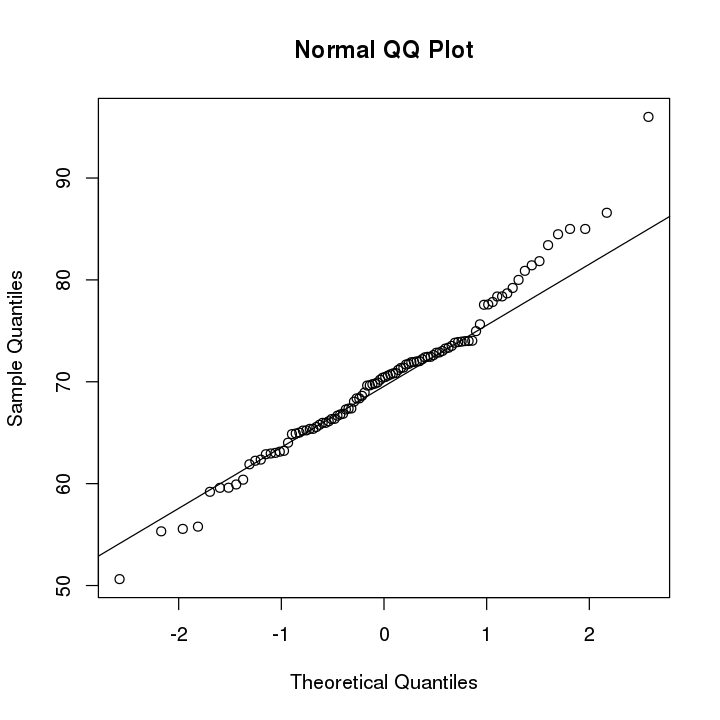

In [43]:
# let's plot this on a qqplot to confirm. 
# Looks pretty normal to me

qqnorm(Y_Var, main = "Normal QQ Plot", plot.it = TRUE, datax = FALSE)
qqline(Y_Var, datax = FALSE)

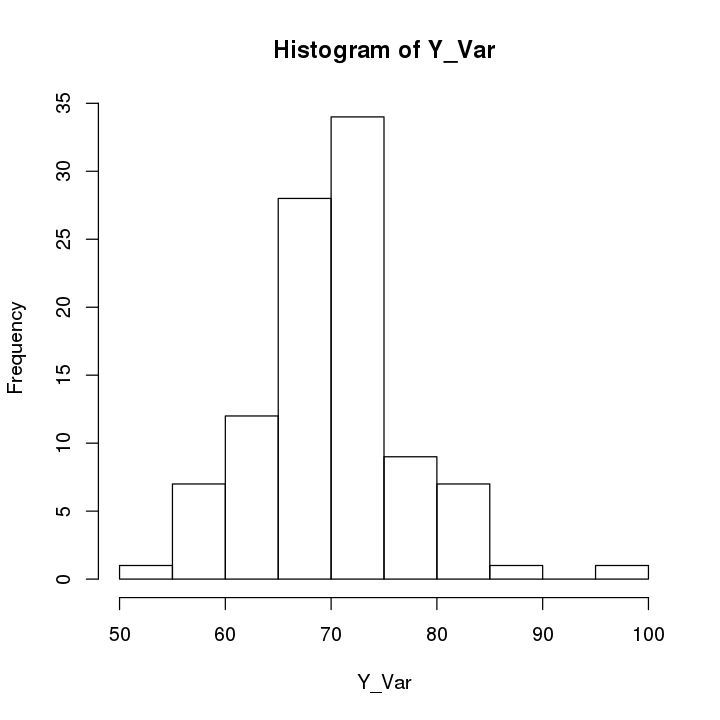

In [45]:
# let's plot the histogram of Y_Var
hist(Y_Var)

Attempt to identify a tranformation that better adjusts its distributional characteristics. 

Plot a histogram of the transformed variable and report the results of a test for normality.  

<b style="color: red;">JACKY: The dependent variable is pretty normal (as stated above) but let's transform it anyway</b>

In [46]:
lambdapwr <- (1/3)
y.Y_Var <- Y_Var^(lambdapwr)

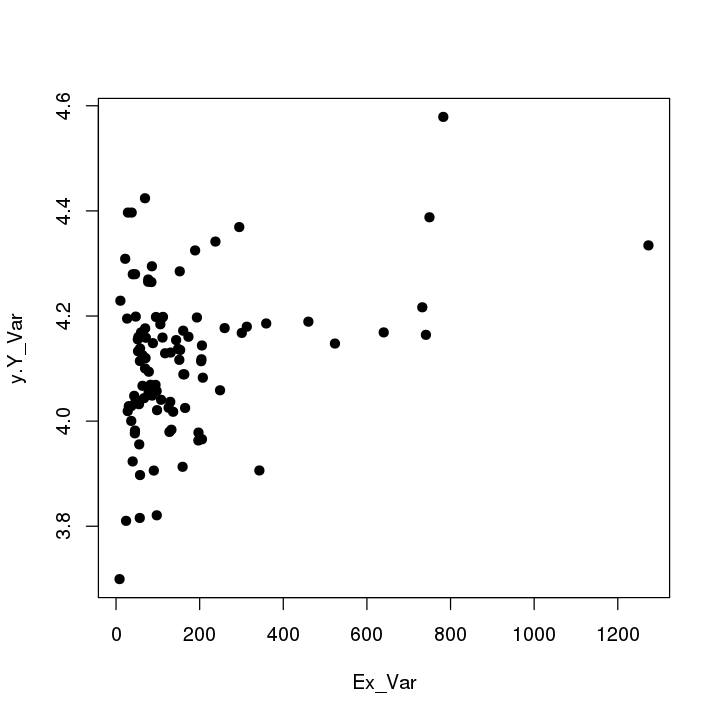

In [47]:
plot(Ex_Var, y.Y_Var, pch = 19)

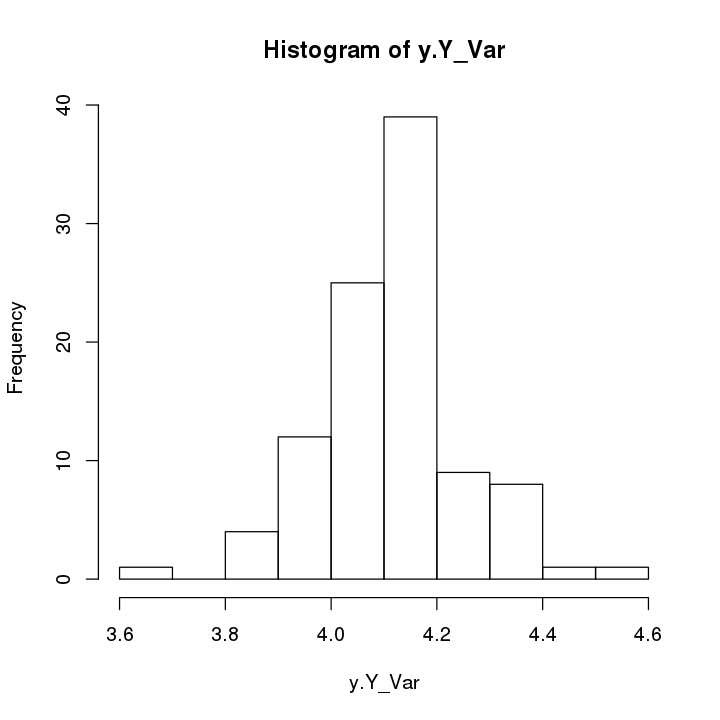

In [48]:
hist(y.Y_Var)

In [49]:
shapiro.test(y.Y_Var)


	Shapiro-Wilk normality test

data:  y.Y_Var
W = 0.98587, p-value = 0.3659


<b style="color: red;">JACKY:</b> 

* Null Hypothesis (H0) = Data is normal
* Alternative Hypothesis (H1) = Data is not normal

<b style="color: red;">RESULTS:</b> 

Assuming an alpha value of 0.05 (95% confidence), we fail to reject the null hypothesis because the p-value is 0.3659. This suggest a level of normality in the data. In fact, the p-value of the transformed Y-Variable is much higher than the previous p-value. 

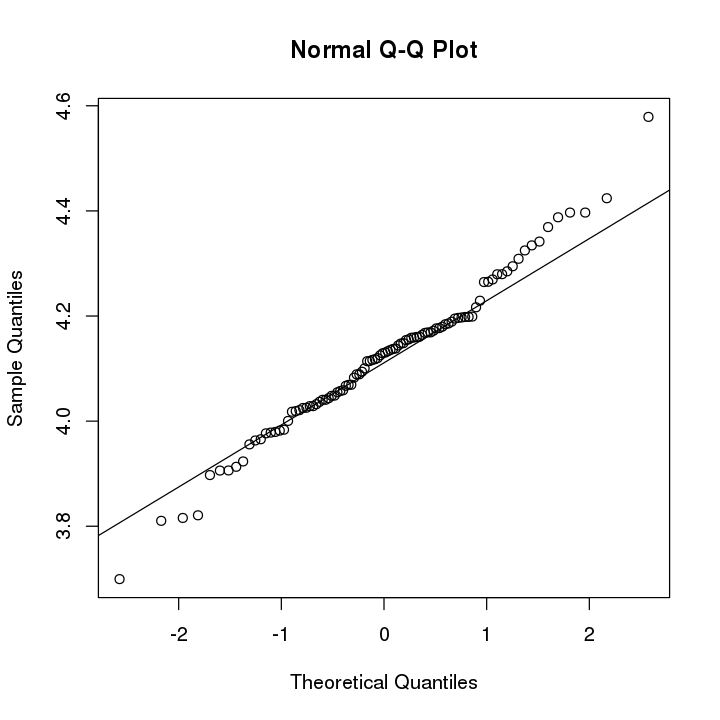

In [52]:
qqnorm(y.Y_Var, plot.it = TRUE, datax = FALSE)
qqline(y.Y_Var, datax = FALSE)

Conduct a regular OLS using the transformed dependent and explanatory variable. 

Summarize the regression output and test the residuals for normality and for spatial autocorrelation at the 90% confidence level. 

In [54]:
Y_Var.lm <- lm(y.Y_Var ~ Ex_Var)

summary(Y_Var.lm)


Call:
lm(formula = y.Y_Var ~ Ex_Var)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38212 -0.07215 -0.00295  0.07053  0.32726 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.079e+00  1.760e-02 231.799  < 2e-16 ***
Ex_Var      2.507e-04  6.901e-05   3.633 0.000448 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1354 on 98 degrees of freedom
Multiple R-squared:  0.1187,	Adjusted R-squared:  0.1097 
F-statistic:  13.2 on 1 and 98 DF,  p-value: 0.0004482


In [55]:
# Let's test the residuals to determine if we can trust the OLS linear regression model.

residuals <- resid(Y_Var.lm)
shapiro.test(residuals)


	Shapiro-Wilk normality test

data:  residuals
W = 0.98502, p-value = 0.3187


<b style="color: red;">JACKY: Same hypotheses as stated above. Residuals look normal to me based on alpha value of 0.05 (95% confidence). Let's test it for the presence of spatial autocorrelation.</b>

In [58]:
resids <- residuals(Y_Var.lm)

moran.test(resids, joined.nb.listb)


	Moran I test under randomisation

data:  resids  
weights: joined.nb.listb  

Moran I statistic standard deviate = 1.479, p-value = 0.06957
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      0.081279434      -0.010101010       0.003817594 


<b style="color: red;">JACKY:</b>

* Null Hypothesis (H0) = There is no spatial autocorrelation in the data. It is all randomness. 
* Alternative Hypothesis (H1) = There is spatial autocorrelation in the data. It is NOT all randomness. 

<b style="color: red;">RESULTS:</b>

* Alpha Value = 0.10 (90% confidence level)
* P-Value = 0.06957
* P-value < Alpha Value

We reject the null hypothesis that it is all randomness. There seems to be some autocorrelation at work in the residuals. Looks like we cannot trust the OLS model just quite yet....

Conduct a SAR specification using the transformed dependent and explanatory variable. 

Summarize the regression output and test the residuals for normality and for spatial autocorrelation at the 90% confidence interval. 

In [65]:
Y_Var_Sar <- errorsarlm(y.Y_Var ~ Ex_Var, listw = joined.nb.listw)

summary(Y_Var_Sar)


Call:errorsarlm(formula = y.Y_Var ~ Ex_Var, listw = joined.nb.listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.390481 -0.086733 -0.002460  0.069418  0.311409 

Type: error 
Coefficients: (asymptotic standard errors) 
              Estimate Std. Error  z value  Pr(>|z|)
(Intercept) 4.0832e+00 2.1132e-02 193.2244 < 2.2e-16
Ex_Var      2.4386e-04 6.9486e-05   3.5095  0.000449

Lambda: 0.26855, LR test value: 3.6354, p-value: 0.056563
Asymptotic standard error: 0.13188
    z-value: 2.0363, p-value: 0.041716
Wald statistic: 4.1467, p-value: 0.041716

Log likelihood: 60.9027 for error model
ML residual variance (sigma squared): 0.017037, (sigma: 0.13053)
Number of observations: 100 
Number of parameters estimated: 4 
AIC: -113.81, (AIC for lm: -112.17)


<b style="color: red;">JACKY: Lambda is positive and statistically significant.</b>

In [66]:
sar_residuals <- residuals(Y_Var_Sar)
shapiro.test(sar_residuals)


	Shapiro-Wilk normality test

data:  sar_residuals
W = 0.99007, p-value = 0.6706


<b style="color: red;">

JACKY: H0 = data is normal while H1 = data is not normal. With alpha = 0.10 (90% confidence), we cannot reject the null hypothesis so the residuals are pretty normal. Let's proceed with the spatial autocorrelation.</b>

In [64]:
moran.test(sar_residuals, joined.nb.listb)


	Moran I test under randomisation

data:  sar_residuals  
weights: joined.nb.listb  

Moran I statistic standard deviate = -0.16589, p-value = 0.5659
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     -0.020354063      -0.010101010       0.003819954 


<b style="color: red;">JACKY: </b>

* H0 = Residuals are random. No signs of autocorrelation. 
* H1 = Residuals show signs of autocorrelation. Not completely random. 

<b style="color: red;">RESULTS: </b>

* P-Value = 0.56
* Alpha Value = 0.10
* P-Value > Alpha Value so we fail to reject the null hypothesis. This indicates that there is no autocorrelation.

Backtransform the fitted SAR values into original measurement units.

In [69]:
Y_Var_Sar$fitted[1:10]

1        2        3        4        5        6        7        8 
4.107319 4.044831 4.079019 4.073268 4.072275 4.074082 4.052165 4.059757 
       9       10 
4.059449 4.078982

In [68]:
backfitted <- Y_Var_Sar$fitted^(1/lambdapwr)

In [70]:
backfitted[1:10]

1        2        3        4        5        6        7        8 
69.29075 66.17608 67.86832 67.58168 67.53225 67.62218 66.53671 66.91138 
       9       10 
66.89619 67.86646

Classify the backtransformed fitted spatially adjusted regression values into 5 quantiles and map. Be sure to add an appropriate legend and map title.

In [71]:
numcat <- 5
cate <- classIntervals(backfitted, numcat, style = "quantile")

In [72]:
pal <- brewer.pal(numcat, "Reds")
cols <- findColours(cate, pal)

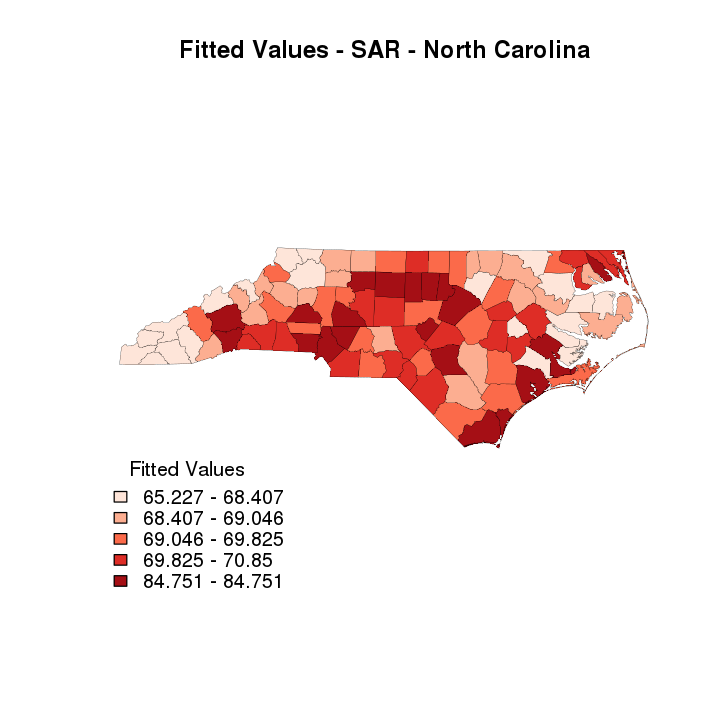

In [74]:
plot(joined, col = cols, lwd = 0.2, main = "Fitted Values - SAR - North Carolina")
brks <- round(cate$brks, 3)
leg <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Fitted Values")

Assess the correlation between the transformed dependent and explanatory variable. 

Then, adjust the dependent variable and explanatory variable independently for spatial autocorrelation and re-calculate their adjusted correlation. 

In [77]:
corr <- cor(y.Y_Var, Ex_Var)

paste("Pearson Correlation: ", corr)

[1] "Pearson Correlation:  0.344513998417584"

In [81]:
Y_Var_Sar2 <- errorsarlm(y.Y_Var ~ 1, listw = joined.nb.listw)
summary(Y_Var_Sar2)


Call:errorsarlm(formula = y.Y_Var ~ 1, listw = joined.nb.listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.420321 -0.093149  0.011291  0.065749  0.422246 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept) 4.123454   0.019877  207.44 < 2.2e-16

Lambda: 0.30616, LR test value: 4.7324, p-value: 0.0296
Asymptotic standard error: 0.12851
    z-value: 2.3823, p-value: 0.017206
Wald statistic: 5.6752, p-value: 0.017206

Log likelihood: 55.1339 for error model
ML residual variance (sigma squared): 0.019021, (sigma: 0.13792)
Number of observations: 100 
Number of parameters estimated: 3 
AIC: -104.27, (AIC for lm: -101.54)


In [88]:
paste("Lambda of SAR Y: ", Y_Var_Sar2$lambda)

[1] "Lambda of SAR Y:  0.306156871434742"

<b style="color: red;">JACKY: Lambda is statistically signicant as indicated by the 0.02 p-value. This indicates that there is spatial autocorrelation at work for this variable </b>

In [86]:
Ex_Var_Sar <- errorsarlm(Ex_Var ~ 1, listw = joined.nb.listw)
summary(Ex_Var_Sar)


Call:errorsarlm(formula = Ex_Var ~ 1, listw = joined.nb.listw)

Residuals:
      Min        1Q    Median        3Q       Max 
-158.7950  -91.4987  -58.2373    4.2448 1060.8649 

Type: error 
Coefficients: (asymptotic standard errors) 
            Estimate Std. Error z value  Pr(>|z|)
(Intercept)  162.861     29.386  5.5422 2.988e-08

Lambda: 0.36763, LR test value: 7.6296, p-value: 0.0057419
Asymptotic standard error: 0.12252
    z-value: 3.0006, p-value: 0.0026942
Wald statistic: 9.0038, p-value: 0.0026942

Log likelihood: -665.9735 for error model
ML residual variance (sigma squared): 34532, (sigma: 185.83)
Number of observations: 100 
Number of parameters estimated: 3 
AIC: 1337.9, (AIC for lm: 1343.6)


In [87]:
paste("Lambda of SAR X:", Ex_Var_Sar$lambda)

[1] "Lambda of SAR X: 0.367628430540467"

<b style="color: red;">JACKY: Lambda is statistically signicant as indicated by the 0.005 p-value. This indicates that there is spatial autocorrelation at work for this variable </b>

In [103]:
# adjust the variables for spatial autocorrelation

Y_Var_sa <- y.Y_Var - Y_Var_Sar2$lambda * lag.listw(joined.nb.listw, y.Y_Var)

Ex_Var_sa <- Ex_Var - Ex_Var_Sar$lambda * lag.listw(joined.nb.listw, Ex_Var)

In [106]:
# recalculate the correlation

paste("Adjusted Correlation: ", cor(Y_Var_sa, Ex_Var_sa))

[1] "Adjusted Correlation:  0.329404223624276"

<b style="color: red;">JACKY: Correlation dropped after being adjusted for spatial autocorrelation. Without accounting for spatial autocorrelation, the correlation would appear to be much higher than it actually is. </b>

Use the spatially adjusted dependent and explanatory variables in a OLS and summarize the results. 

Test for normality of the model residuals and for spatial autocorrelation in the residuals at the 90% confidence interval. 

In [107]:
Y_Var_lm_sa <- lm(Y_Var_sa ~ Ex_Var_sa)

summary(Y_Var_lm_sa)


Call:
lm(formula = Y_Var_sa ~ Ex_Var_sa)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.39322 -0.08821 -0.00145  0.07113  0.31096 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.836e+00  1.504e-02 188.561  < 2e-16 ***
Ex_Var_sa   2.445e-04  7.079e-05   3.454 0.000818 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1315 on 98 degrees of freedom
Multiple R-squared:  0.1085,	Adjusted R-squared:  0.09941 
F-statistic: 11.93 on 1 and 98 DF,  p-value: 0.0008183


In [108]:
# testing normality of the residuals

residuals_sa <- residuals(Y_Var_lm_sa)

shapiro.test(residuals_sa)


	Shapiro-Wilk normality test

data:  residuals_sa
W = 0.99071, p-value = 0.7223


<b style="color: red;">JACKY: H0 = data is normal while H1 = data is not normal. Using an alpha value of 0.10 (90% confidence), we fail to reject the null hypothesis...indicating that the residuals are normal. Let's continue</b>

In [109]:
moran.test(residuals_sa, joined.nb.listb)


	Moran I test under randomisation

data:  residuals_sa  
weights: joined.nb.listb  

Moran I statistic standard deviate = -0.4046, p-value = 0.6571
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
      -0.03510828       -0.01010101        0.00382017 


<b style="color: red;">JACKY: </b>

* H0 = Data is random. No spatial autocorrelation
* H1 = Data is not random. Signs of spatial autocorrelation.

<b style="color: red;">RESULTS: </b>
* P-Value = 0.65
* Alpha Value = 0.10
* Fail to reject the null hypothesis. This indicates that the residuals are random and was effectively treated by the adjustment process. 